In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from scvi.model import CondSCVI, DestVI

sc.set_figure_params(figsize=(4, 4), frameon=False)

%load_ext lab_black

Global seed set to 0


In [11]:
root = pathlib.Path("/Users/giovanni.palla/Datasets/advomics")
sc_adata = sc.read(root / "GSE156793_fetal_heart_scNym_RAW_ctl201119.h5ad")
sc_adata.var_names_make_unique()
sc.pp.subsample(sc_adata, fraction=0.3, random_state=42)
filter_clusters = sc_adata.obs.Main_cluster_name.value_counts().index.values[
    sc_adata.obs.Main_cluster_name.value_counts() > 50
]
sc_adata = sc_adata[sc_adata.obs.Main_cluster_name.isin(filter_clusters)].copy()
G = 2000
sc.pp.filter_genes(sc_adata, min_counts=10)

sc_adata.layers["counts"] = sc_adata.X.astype(np.float64).copy()
sc_adata = sc_adata[
    sc_adata.obs.Main_cluster_name != "Erythroblasts"
].copy()  # remove Erythroblasts cause they are too few
sc.pp.highly_variable_genes(
    sc_adata, n_top_genes=G, subset=True, layer="counts", flavor="seurat_v3"
)
sc.pp.normalize_total(sc_adata, target_sum=10e4)
sc.pp.log1p(sc_adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/giovanni.palla/miniconda3/envs/advomics/lib/python3.8/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD113-1', 'SNORD113-2', 'SNORD113-3']
  warnings.warn(


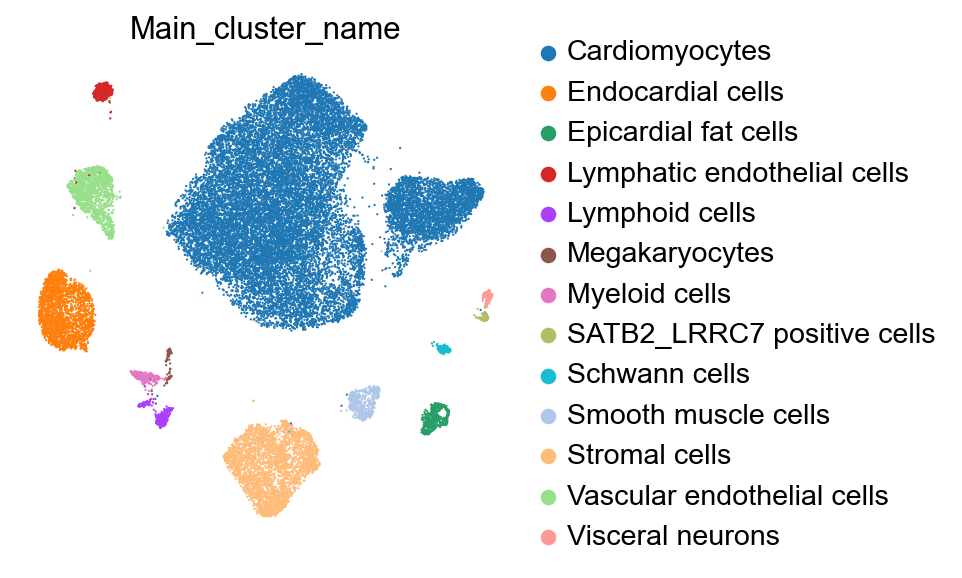

In [12]:
sc.pl.umap(sc_adata, color="Main_cluster_name")

In [14]:
st_adata = sc.read(root / "spatial_adata/V10F24-105_A1.h5ad")
st_adata.layers["counts"] = st_adata.X.astype(np.float64).copy()
st_adata.var_names_make_unique()
sc.pp.normalize_total(st_adata, target_sum=10e4)
sc.pp.log1p(st_adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [45]:
import imageio
from skimage.util import img_as_ubyte

imageio.imwrite(
    root / "V10F24-105_A1.png",
    img_as_ubyte(st_adata.uns["spatial"]["V10F24-105_A1"]["images"]["hires"]),
)

In [48]:
st_adata.uns["spatial"]["V10F24-105_A1"]["scalefactors"]["tissue_hires_scalef"]

0.04155585

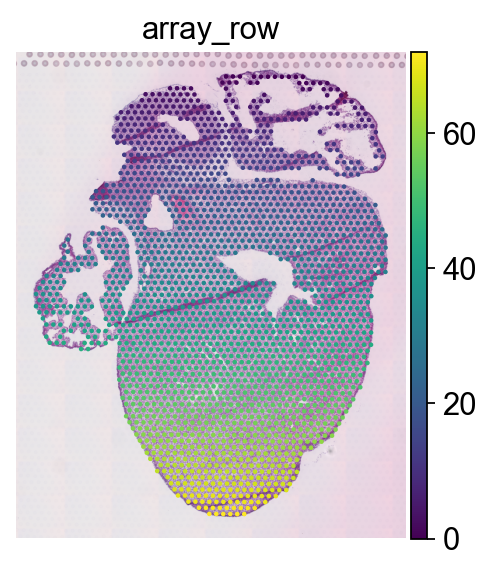

In [15]:
sc.pl.spatial(st_adata, color="array_row")

In [16]:
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()
G = len(intersect)

In [17]:
from scvi.external import RNAStereoscope, SpatialStereoscope

RNAStereoscope.setup_anndata(sc_adata, layer="counts", labels_key="Main_cluster_name")

In [18]:
sc_adata.layers["counts"]

<28931x1443 sparse matrix of type '<class 'numpy.float64'>'
	with 945288 stored elements in Compressed Sparse Row format>

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 100/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:02<00:00,  3.03s/it, loss=1.64e+04, v_num=1]


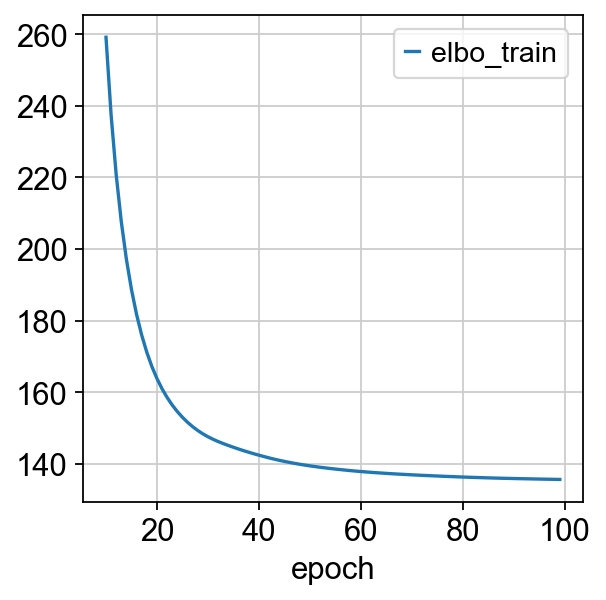

In [19]:
train = True
if train:
    sc_model = RNAStereoscope(sc_adata)
    sc_model.train(max_epochs=100, use_gpu=False, lr=0.01)
    sc_model.history["elbo_train"][10:].plot()
    sc_model.save("scmodel", overwrite=True)
else:
    sc_model = RNAStereoscope.load("scmodel", adata=sc_adata)
    print("Loaded RNA model from file!")

In [38]:
st_adata

AnnData object with n_obs × n_vars = 2169 × 1443
    obs: 'in_tissue', 'array_row', 'array_col', '_indices'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'curated_landmarks', 'spatial', 'log1p', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'spatial'
    layers: 'counts'

In [20]:
st_adata.layers["counts"] = st_adata.X.copy()
SpatialStereoscope.setup_anndata(st_adata, layer="counts")

/Users/giovanni.palla/miniconda3/envs/advomics/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [21]:
train=True
if train:
    spatial_model = SpatialStereoscope.from_rna_model(st_adata, sc_model)
    spatial_model.train(max_epochs = 500)
    spatial_model.history["elbo_train"][10:].plot()
    spatial_model.save("stmodel", overwrite = True)
else:
    spatial_model = SpatialStereoscope.load("stmodel", adata=st_adata)
    print("Loaded Spatial model from file!")

/Users/giovanni.palla/miniconda3/envs/advomics/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 1/500:   0%|                                                                                                                                                                | 0/500 [00:00<?, ?it/s]

ValueError: Expected value argument (Tensor of shape (128, 1443)) to be within the support (IntegerGreaterThan(lower_bound=0)) of the distribution NegativeBinomial(total_count: torch.Size([128, 1443]), logits: torch.Size([128, 1443])), but found invalid values:
tensor([[2.7620, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [3.5518, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [3.3636, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [2.1669, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])